# Trim results to smaller areas

In [1]:
import sys
import os
import folium
import numpy.ma as ma
from folium import Map, FeatureGroup, LayerControl
import rasterio
from shapely.geometry import box
import geopandas as gpd
from pyproj import CRS
from rasterio.mask import mask
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import rioxarray as rxr
from rasterio import plot
from shapely.geometry import mapping
import glob 

# Define whether to filter out values <0.1
remove_little_values = True

os.chdir('../ProcessModelResults/IdealisedProfiles/')
from my_functions_idealisedprofiles import *

### Read in the catchment boundary, and the boundaries for Kippax and Garforth

In [20]:
model_directory = '../../../../FloodModelling/Model_IdealisedProfiles/'

# Specify catchment area to add to plot
catchment_gdf = gpd.read_file('../../../../FloodModelling/Model_IdealisedProfiles/CatchmentLinDyke_exported.shp')

# Specify Kippax boundary
all_boundaries = gpd.read_file("../../../../FloodModelling/KippaxBoundary/Parishes/Parishes_December_2016_FCB_in_England_and_Wales.shp")
kippax_boundary = all_boundaries[all_boundaries['par16nm'] == 'Kippax']

# Garforth boundary
garforth_boundary = gpd.read_file("../../../../FloodModelling/GarforthBoundary/Garforth_edited.shp")
# Convert crs to BNG
garforth_boundary = garforth_boundary.to_crs("epsg:27700") 

# NW boundary
nw_area_boundary = gpd.read_file("../../../../FloodModelling/GarforthBoundary/TestBoundary.shp")
# Convert crs to BNG
nw_area_boundary = nw_area_boundary.to_crs("epsg:27700") 

# NW boundary
se_area_boundary = gpd.read_file("../../../../FloodModelling/GarforthBoundary/TB_South.shp")
# Convert crs to BNG
se_area_boundary = se_area_boundary.to_crs("epsg:27700") 

## Trim model results to Garforth/Kippax boundary

### Idealised profiles

In [4]:
methods =[ '6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']

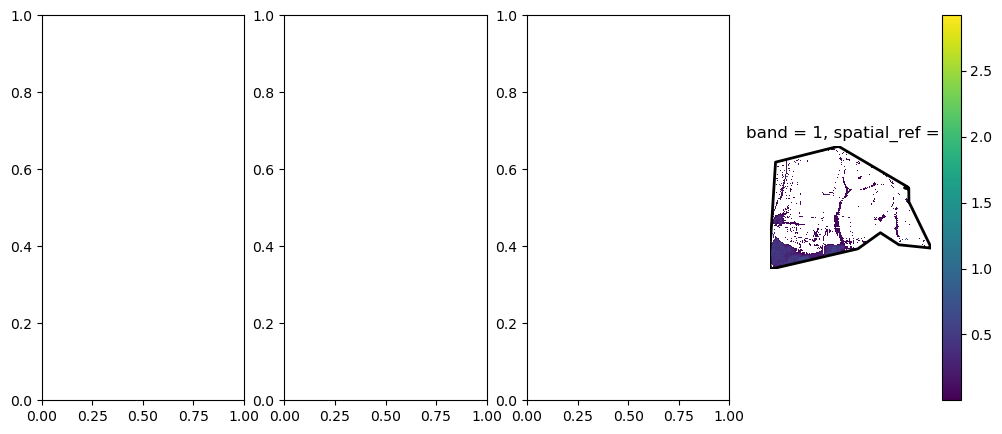

In [29]:
fig, axs =plt.subplots(ncols=4, figsize =(12,5))
for region_name in ['SE_area']:#, 'NW_area', 'Kippax']:
    # Select boundary name
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    elif region_name == 'NW_area':
        region_boundary = nw_area_boundary
    elif region_name == 'SE_area':
        region_boundary = se_area_boundary    
        
    # Trim for each method        
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for number, file in enumerate(files):
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    
            
            if number == 0 and region_name == 'Kippax' and method == '6h_sp_c_0.5':
                raster_clipped.plot.imshow(ax=axs[0])
                kippax_boundary.plot(ax=axs[0], facecolor="none", edgecolor= 'black', linewidth=2)
                axs[0].set_axis_off()
            elif number ==0  and region_name == 'Garforth'and method == '6h_sp_c_0.5':
                raster_clipped.plot.imshow(ax=axs[1])
                garforth_boundary.plot(ax=axs[1], facecolor="none", edgecolor= 'black', linewidth=2)
                axs[1].set_axis_off()
            elif number ==0  and region_name == 'NW_area'and method == '6h_sp_c_0.5':
                raster_clipped.plot.imshow(ax=axs[2])
                nw_area_boundary.plot(ax=axs[2], facecolor="none", edgecolor= 'black', linewidth=2)
                axs[2].set_axis_off()      
            elif number ==0  and region_name == 'SE_area'and method == '6h_sp_c_0.5':
                raster_clipped.plot.imshow(ax=axs[3])
                se_area_boundary.plot(ax=axs[3], facecolor="none", edgecolor= 'black', linewidth=2)
                axs[3].set_axis_off()                      

### Idealised profiles (scaled)

In [6]:
model_directory = '../../../../FloodModelling/Model_IdealisedProfiles_Scaled/'

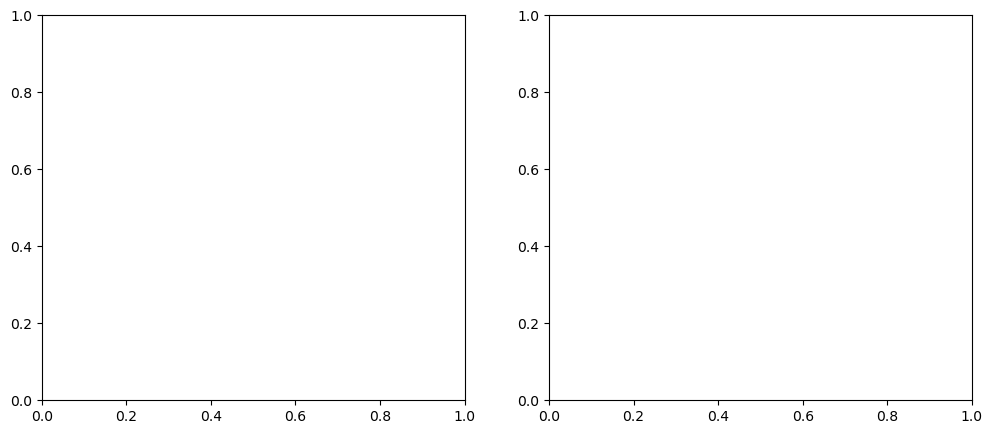

In [7]:
fig, axs =plt.subplots(ncols=2, figsize =(12,5))
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for number, file in enumerate(files):
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    

### Idealised profiles (drier antecedent conditions)

In [44]:
model_directory = '../../../../FloodModelling/Model_IdealisedProfiles_drierConditions/'

In [ ]:
fig, axs =plt.subplots(ncols=2, figsize =(12,5))
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for number, file in enumerate(files):
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    

### Observed profiles

In [16]:
model_directory = '../../../../FloodModelling/Model_ObservedProfiles/'

In [17]:
methods = ['6h_feh_singlepeak', '6h_c1','6h_c8','6h_c15','6h_c3','6h_c11','6h_c10','6h_c9','6h_c13','6h_c6',
 '6h_c2','6h_c12','6h_c14','6h_c4','6h_c7','6h_c5']  

In [20]:
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        if method == '6h_feh_singlepeak':
            path = '../../../../FloodModelling/Model_FEHProfiles/{}/{}'.format(method, region_name)
        else:
            path = model_directory + method + '/{}/'.format(region_name)
        # Create subdirectory for outputs
        if not os.path.exists(path):
            os.mkdir(path)
        # Find all files in the directory
        files = glob.glob(path.replace('/{}'.format(region_name), '') + '/'+ '*.tif')
        # Loop through each file and create a filtered version
        for file in files:
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(path + '/' + file.split('/')[-1])    

### Single peak (scaled)

In [ ]:
model_directory = '../../../../FloodModelling/Model_SinglePeak_Scaled/'

In [ ]:
methods = ['6h_sp_+0','6h_sp_+05','6h_sp_+10','6h_sp_+20','6h_sp_+30']  

In [ ]:
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for file in files:
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    